In [1]:
# Yuchen ZHU, Mar 04, 2020

import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import os
import time
import pickle
from mpl_toolkits.mplot3d import Axes3D
import numba

# initialize some global variables
'''
Liquid :
---------
    L = 30
    cutOff = 14

Gas :
------
    L = 182
    cutOff = 50

temperature :
-------------
    100, 200, 300, and 400
'''

state = 'liquid'

if state == 'gas':
    L = 182 # box size    30 182
    cutOff = 50 #[A]    14 50
elif state == 'liquid':
    L = 30 # box size    30 182
    cutOff = 14 #[A]    14 50    

kb = 1.380649E-23 #[J/K]
NA = 6.02214076E23 #[1/mol]
Rgas = 8.3144621 #[J/(mol*K)]
R = kb * NA * 1e-3 /4.184 # [kcal/(mol*K)] another gas constant 0.0019872041 
molarMass = 16.04 # [g/mol] for CH4
Temperature = 150 #[K]

sigma = 3.73
epsilon = 148
nPart = 362   
# 1 cal = 4.184 J
energyTail = 1/3 * (sigma/cutOff)**9 - (sigma/cutOff)**3
energyTail *= 8/3 * np.pi * (nPart/L**3) * epsilon * sigma**3 
energyTail *= nPart # tail energy is particle property [K]

# MD solver variables
steps = 10000 #10000  3000
nFreq = 100

# thermostat variables:
Q = 1592e3 # damping variable [m*x]
var = Temperature*kb/(nPart * molarMass/NA) * 1e-7 #[A**2/fs**2]
xiArray = np.random.normal(0, var**0.5, nPart )   # var**0.5, for old version
xi = 0 # initialize as 0

In [2]:
# Functions provided in the assignments 
# ===================================================================

def write_frame(coords, L, vels, forces, trajectory_name, step):
    '''
    function to write trajectory file in LAMMPS format

    output can be read in in VMD using the provided vis.vmd script using
    vmd -e vis.vmd
    You may need to adjust name of trajectory file in vis.vmd

    In VMD you can visualize the motion of particles.


    :param coords: coordinates
    :param vels: velocities
    :param forces: forces
    :param trajectory_name: trajectory filename

    :return:
    '''

    nPart = len(coords[:, 0])
    nDim = len(coords[0, :])
    with open(trajectory_name, 'a') as file:
        file.write('ITEM: TIMESTEP\n')
        file.write('%i\n' % step)
        file.write('ITEM: NUMBER OF ATOMS\n')
        file.write('%i\n' % nPart)
        file.write('ITEM: BOX BOUNDS pp pp pp\n')
        for dim in range(nDim):
            file.write('%.6f %.6f\n' % (-0.5 * L, 0.5 * L))
        for dim in range(3 - nDim):
            file.write('%.6f %.6f\n' % (0, 0))
        file.write('ITEM: ATOMS id type xu yu zu vx vy vz fx fy fz\n')

        temp = np.zeros((nPart, 9))
        for dim in range(nDim):
            temp[:, dim] = coords[:, dim]
            temp[:, dim + 3] = vels[:, dim]
            temp[:, dim + 6] = forces[:, dim]

        for part in range(nPart):
            file.write('%i %i %.4f %.4f %.4f %.6E %.6E %.6E %.4E %.4E %.4E\n' % (part + 1, 1, *temp[part, :]))

  
# functions for rdf computing
# ===================================================================

def write_xyz_traj(r, Npart, filename):
	'''
		This function appends a frame to the end of a xyz file. 
		
		: r : 			position of the particles in the form of [[x1,y1,z1],[x2,y2,z2] ... [xN,yN,zN]]
		: Npart :		number of particles (int)
		: filename :	name of the trajectory file where the frame gets appended (str)

	'''
	output_box0 = open(filename + '.xyz', 'a')
	output_box0.write('%0.0i\n\n' % Npart)
	[output_box0.write('%s\t%0.5f\t%0.5f\t%0.5f\n' % ("C", r[i, 0], r[i, 1], r[i, 2])) for i in range(0, Npart)]
	output_box0.close()
    
def read_xyz_trj(file_name):

    xyz_file = open(file_name, 'r')

    frame = 0
    xyz = {}
    READING=True
    while READING:
        try:
            nparts = int(xyz_file.readline())
            xyz_file.readline()
            xyz[frame] = np.zeros([nparts, 3])
            for k in range(0, nparts):
                line = xyz_file.readline()
                line = line.split()
                xyz[frame][k, 0] = line[1]
                xyz[frame][k, 1] = line[2]
                xyz[frame][k, 2] = line[3]
            frame += 1
        except:
            print("Reach end of '" + file_name + "'")
            READING=False

    return xyz

# @numba.jit(nopython=True)
def rdf(xyz, LxLyLz, n_bins=100, r_range=(0.01, 10.0)):
    '''
    rarial pair distribution function

    :param xyz: coordinates in xyz format per frame
    :param LxLyLz: box length in vector format
    :param n_bins: number of bins
    :param r_range: range on which to compute rdf
    :return:
    '''

    g_r   = np.histogram(0, bins=n_bins, range=r_range)[0]
    edges = np.histogram(0, bins=n_bins, range=r_range)[1]
    g_r[0] = 0
    g_r = g_r.astype(np.float64)
    rho = 0
    
    for i, xyz_i in enumerate(xyz):
        xyz_j = np.vstack((xyz[:i], xyz[i + 1:]))
        d = np.abs(xyz_i - xyz_j)
        d = np.where(d > 0.5 * LxLyLz, LxLyLz - d, d)                    
        d = (np.sum(d ** 2, axis=-1))**0.5
        temp_g_r = np.histogram(d, bins=n_bins, range=r_range)[0]
        g_r += temp_g_r

    rho += (i + 1) / np.prod(LxLyLz)
    r = 0.5 * (edges[1:] + edges[:-1])
    V = 4./3. * np.pi * (np.power(edges[1:], 3) - np.power(edges[:-1], 3))
    norm = rho * i
    g_r /= norm * V

    return r, g_r



[[-13.125 -13.125 -13.125]
 [ -9.375 -13.125 -13.125]
 [ -5.625 -13.125 -13.125]
 [ -1.875 -13.125 -13.125]
 [  1.875 -13.125 -13.125]
 [  5.625 -13.125 -13.125]
 [  9.375 -13.125 -13.125]]


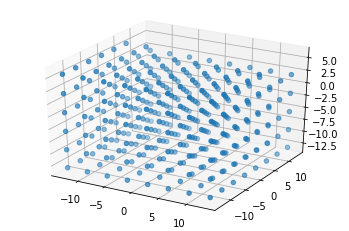

In [3]:
def initGrid(L, nPart, dim):
    '''
    function to determine particle positions and box size for a specified number of particles and density

    Start at the empty array coords in which we will place the coordinates of the particles.
    Create an additional variable called L which shall give the box dimension (float).
    Make sure to shift the coordinates to have (0,0,0) as the center of the box.

    Fill the box with particles without overlap and correct density

    You can check the positioning of particles using a scatter plot
    import matplotlib.pyplot as plt
    plt.figure()
    plt.scatter(x, y)
    plt.show()

    :param L: box dimension
    :param rho: density of particles [number per unit length]
    
    Input:
    --------
    [0] : float
        the box size
    [1] : int
        number of particles in the box
    [2] : int
        dimension of the system
        
    output:
    ---------
    [0]: array like, shape (n, 3)
        coordinates centered around origin
        
    [1]: float, 
        box size
    '''

    # load empty array for coordinates
    coords = np.zeros((nPart, dim))

    # Find number of particles in each lattice line
    n = np.ceil(nPart ** (1 / dim)) 

    # define lattice spacing
    spac = L / n

    # initiate lattice indexing
    index = np.zeros(dim)

    # assign particle positions
    for part in range(nPart):
        coords[part, :] = index * spac + spac/2

        # advance particle position
        index[0] += 1

        # if last lattice point is reached jump to next line
        if index[0] >= n and len(index)>1:
            index[0] = 0
            index[1] += 1
            if index[1] >= n and len(index)>2:
                index[1] = 0
                index[2] += 1                
    return coords - L / 2

coords = initGrid(L, nPart, 3)
coords_1 = initGrid(L, int(nPart*0.5), 3)
coords_2 = initGrid(L, nPart*2, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[:,0], coords[:,1], coords[:,2])

print(coords[:7, :])


In [4]:
def initVel(coords, Temperature, mass, kB, nDim):
    '''
    Initiate velocities by drawing random numbers from numpy random

    Inputs:
    ---------
    [0] : array of (n,3)
        coordinates of all particles
    [1] : float
        temperature of the system
    [2] : float
        molar mass of atom, 16.04 g/mol
    [3] : float
        kb constant
    [4] : int
        dimension of the system
        
    Outputs:
    --------
    [0] : array of (n,3)
        initial velocity of the system [A/fs], projected on x, y, z axis
    
    '''
    # initialize some useful variables
    massCH4 = mass/NA/1000
    meanVelocitySq = (nDim*kB*Temperature/massCH4)
    
    # lower deviation value for better statistics 
    velocityMagnArray = np.random.normal(meanVelocitySq, meanVelocitySq*0.00001, size = coords.shape[0] )
    velocityMagnArray = velocityMagnArray**0.5
    velocityArray = np.zeros(coords.shape)
    
    # generate random directions
    magn = np.zeros(coords.shape[0])
    dirc = np.random.uniform( low = -0.5, high = 0.5, size = coords.shape)
    for i in range(coords.shape[0]):
        magn[i] = np.linalg.norm(dirc[i, :])
        dirc[i, :] = dirc[i, :] / magn[i]
        velocityArray[i, :] = velocityMagnArray[i]*dirc[i, :]
    
    return velocityArray * 1e-5 # [m/s] to [A/fs]

vels = initVel( coords, Temperature, molarMass, kb, 3 )
# b = np.zeros(362)
# for i in range(362):
#     b[i] = np.linalg.norm(a[i, :])
# b = b**2
# np.sum(b) / len(b)

print(vels)

[[-0.00294067  0.001714    0.00342642]
 [ 0.00341611  0.00292433  0.00176207]
 [-0.00060456  0.00371749  0.00302336]
 ...
 [-0.00108646  0.00309832  0.00354205]
 [-0.00205154 -0.0035891   0.00249713]
 [-0.00095515 -0.00332353  0.00337162]]


In [5]:
@numba.jit(nopython=True) 
def LJ_forces(coords):
    '''
    function to compute LJ forces between particles
    
    Inputs:
    --------
    [0] : array of (n,3) 
        position of partilces
    [1] : float
        box size

    Outputs: 
    ---------
    [0] : array of (n,3)
        LJ forces
    '''
    debug = []
    # initialize empty array for forces
    forces = np.zeros(coords.shape)

    # obtain number of particles
    nPart = coords.shape[0]    
    
    # compute forces between all particles
    for i in range(nPart):
        for j in range(i + 1, nPart):
            
            # get the direction, apply pbc
            dirc = coords[j, :] - coords[i, :]
            for k in range(len(dirc)):
                if dirc[k] < -0.5*L:
                    dirc[k] = dirc[k] + L
                elif dirc[k] > 0.5*L:
                    dirc[k] = dirc[k] - L
            
            # compute distance and adjust for PBC
            distance = np.linalg.norm(dirc)
            unitDirction = dirc / distance
            
            # implement force equation
            if distance < cutOff and distance > 0:
                forceMagnitude = -24*epsilon/distance *\
                                 (2*(sigma/distance)**12 - (sigma/distance)**6)
                force = forceMagnitude * unitDirction
                debug.append(forceMagnitude)
                # write forces, sign reference is the coords 
                forces[i, :] += force
                forces[j, :] -= force #[K/A]
    return forces * Rgas * 1e-7   #convert into [A*g/(mol* fs**2)] 

forces = LJ_forces(coords)


    




In [6]:
@numba.jit(nopython=True) 
def potentialEnergy(coords):
    '''
    Inputs:
    ---------
    [0] : array of (362,3)
        the coordinates of the system
    
    Output:
    --------------
    [0] : float, 
        the total energy of lj potential
        
        
    parameters:
    ------------
    temp0 : float, 
        the lj potential for each pair
        

    '''
    energyLj = 0
    for i in range(nPart):
        for j in range(i+1):
            
            # sign multiple values at one time will solw numba greatly 
            dx = abs(coords[i, 0] - coords[j, 0])
            dy = abs(coords[i, 1] - coords[j, 1])
            dz = abs(coords[i, 2] - coords[j, 2])           
            if dx > (0.5 * L):
                dx = L - dx
            if dy > (0.5 * L):
                dy = L - dy
            if dz > (0.5 * L):
                dz = L - dz
            r = (dx*dx + dy*dy + dz*dz)**0.5
            
            if r < cutOff and r > 0:
                temp0 = 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)
                energyLj += temp0
    PE = energyLj  #[K]      + energyTail
    return PE * R #[kcal/(mol)]  

@numba.jit(nopython=True) 
def kineticEnergy(vels):
    '''
    Inputs:
    --------
    [0] : array of (362,3)
        the coords of the system, [A/fs]
        
    Outputs:
    --------
    [0] : float
        the total KE of the system, [Kcal/mol]
        
    '''
    KE = 0.5 * molarMass * np.sum(np.multiply(vels , vels))
    
    return KE * 1e+4 / 4.184 # convert into [Kcal/mol]

@numba.jit(nopython=True) 
def fnTemperature(KE):
    '''
    Inputs: 
    -------
    [0] : float
        KE of the system, [kcal/mol]
        
    Output:
    -------
    [0] : float
        temperature of the system, [K]
    '''
    KE *= 4.184 # convert into [kJ/mol] 
    T = 2 * KE / (3 * nPart * Rgas *1e-3 )
    return T

@numba.jit(nopython=True) 
def fnPressure(coords):
    '''
    Inputs:
    --------
    [0] : array of (362, 3)
        coords of the system
        
    Output:
    -------
    [0] : float
        virial pressure of the system , [Pa]
    '''
    virialPre = nPart * Temperature
    for i in range(nPart):
        for j in range(i + 1):
            
            # sign multiple values at one time will solw numba greatly 
            dx = abs(coords[i, 0] - coords[j, 0])
            dy = abs(coords[i, 1] - coords[j, 1])
            dz = abs(coords[i, 2] - coords[j, 2])           
            if dx > (0.5 * L):
                dx = L - dx
            if dy > (0.5 * L):
                dy = L - dy
            if dz > (0.5 * L):
                dz = L - dz
            r = (dx*dx + dy*dy + dz*dz)**0.5
            
            if r < cutOff and r > 0:
                
                temp1 = 4 * epsilon * ( 4*(sigma/r)**12 - 2*(sigma/r)**6 )
                virialPre += temp1
                
    virialPre *= kb/(L*1e-10)**3  # [Pa]
    return virialPre /1e6 # [MPa]       

@numba.jit(nopython=True) 
def averages(variableHistory):
    '''
    Inputs:
    [0] : array of (n,)
    An array containing history of the concerned variable 
    
    
    Outputs:
    [0] : float, 
        average of the array     
    [1] : float,
        standard deviation of the array
    
    '''
    
    avg = np.mean(variableHistory)
    var = np.mean( (variableHistory - avg)**2 )
    sd = var**0.5
    
    return avg, sd



In [7]:
@numba.jit(nopython=True) 
def velocityVerlet(coords, forces, vels, ts):
    '''
    Input :
    --------
    [0] : array of (362,3)
        coords of the system, [A]
    [1]: array of (362,3)
        forces of the system, [A*g/(mol* fs**2)]
    [2] : array of (362,3)
        vels of the system, [A/fs]
    [3] : time step
        1
    
    Output :
    -----------
    updated corresponding variables
    
    '''
    vels = vels.copy()
    coords = coords.copy()
    forces = forces.copy()
    
    for i in range(coords.shape[0]):
        
        coordNew = coords[i, :] + vels[i, :]* ts + forces[i, :]* ts**2 / (2*molarMass)
               
        # check pbc, no use same counter name multiple times !!!!!!!!!
        for j in range(3):
            if coordNew[j] < -0.5*L:
                coordNew[j] += L
            if coordNew[j] > 0.5*L:
                coordNew[j] -= L
        
        # update the velocity and coords 
        coords[i, :] = coordNew
        vels[i, :] += forces[i, :]*ts/(2*molarMass)
    

    # jump to next time instance
    forces = LJ_forces(coords) 

    # update the last half part
    for i in range(coords.shape[0]):
        vels[i, :] += forces[i, :]*ts/(2*molarMass)
    
    
    return coords, forces, vels 



In [8]:

@numba.jit(nopython=True) 
def velocityVerletThermostat(coords, forces, vels, xi, Q, ts):
    '''
    Instruction:
    ---------------
    This is the updated version of thermostat. Old one is commented out. Update the system with thermostat
    
    Inputs:
    --------
    [0] : array of (n,3)
        coords of the system, [A]
    [1]: array of (362,3)
        forces of the system, [A*g/(mol* fs**2)]
    [2] : array of (362,3)
        vels of the system, [A/fs]
    [3] : float
        xi parameter
    [4] : float
        damping parameter
    [5] : time step
        constant of 1
        
    Output :
    -----------
    updated coords, forces, vels, xi
    
    '''
    # initi variables
    coords = coords.copy()
    forces = forces.copy()
    vels = vels.copy()
    
    # eq 3. Update locations
    for i in range(coords.shape[0]):
        # Update coords
        coordNew = coords[i, :] + vels[i, :]*ts + ts**2/2 * \
                    (forces[i,:]/molarMass - xi*vels[i, :])
        
        # check pbc
        for j in range(3):
            if coordNew[j] < -0.5*L:
                coordNew[j] += L
            if coordNew[j] > 0.5*L: 
                coordNew[j] -= L
        coords[i, :] = coordNew
        
    # eq 4. Update first half of xi 
    xi += 0.5*ts/Q * ( kineticEnergy(vels)\
                       - (3*nPart+1)*0.5 * R * Temperature) 
    
    # eq 5. Update first half of v
    for i in range(coords.shape[0]): 
        vels[i, :] += ts/2 * (forces[i, :]/molarMass - xi*vels[i,:])  
        
    # eq 6. Jump to the next time instance
    forces = LJ_forces(coords)  
    
    # eq 7. Update second half of xi    
    xi += 0.5*ts/Q * ( kineticEnergy(vels)\
                           - (3*nPart+1)*0.5 * R * Temperature)
        
    # eq 8. Update second half of v
    for i in range(coords.shape[0]):
        vels[i, :] = (vels[i, :] + ts/2 * (forces[i, :]/molarMass))\
                                                    /(1 + ts/2 *xi )   
    
    return coords, forces, vels, xi



0 149.9563 411.4822 161.8106 -407.2704 -245.4598
100 128.0075 416.1862 138.1267 -384.5256 -246.3989
200 214.1281 251.7467 231.0553 -477.1002 -246.0449
300 264.3598 132.1726 285.2579 -531.0258 -245.7679
400 258.8053 88.7794 279.2644 -524.8193 -245.5549
500 251.9349 52.5126 271.8508 -517.2600 -245.4091
600 247.4912 26.8036 267.0558 -512.3474 -245.2917
700 229.3593 30.0782 247.4906 -492.7163 -245.2258
800 227.4767 24.7096 245.4591 -490.6623 -245.2031
900 223.5625 28.5684 241.2356 -486.4502 -245.2146
1000 217.8450 36.7969 235.0661 -480.2978 -245.2318
1100 217.5309 39.5426 234.7271 -479.9679 -245.2409
1200 206.3353 63.6269 222.6465 -467.8733 -245.2268
1300 216.7552 47.2305 233.8901 -479.1162 -245.2261
1400 212.2880 54.8684 229.0697 -474.2876 -245.2179
1500 204.8175 64.4180 221.0087 -466.2365 -245.2277
1600 215.3134 47.0297 232.3343 -477.5659 -245.2316
1700 218.1310 42.9092 235.3747 -480.6159 -245.2413
1800 207.7220 57.9811 224.1428 -469.3670 -245.2242
1900 214.3266 45.1662 231.2695 -476.481

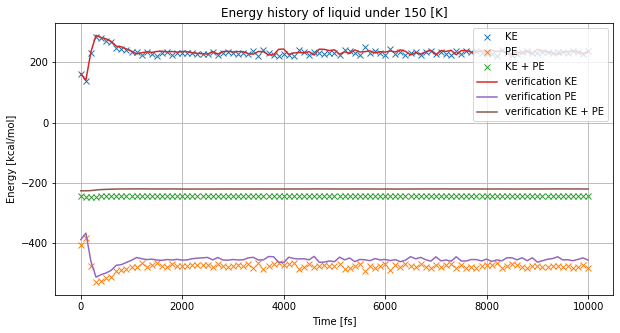

In [9]:
# MD solver
def solverMD():
    '''
    10000 steps cost around 5 [mins], producing two files. 
    
    md.dat : 
        thermodynamics history data file for the simulation steps. 
    md.trj : 
        lammps trj file for the simulation steps.
    
    '''
    
    coordsTemp = coords.copy()
    forcesTemp = forces.copy()
    velsTemp  = vels.copy()
    
    # statistics variables
    historyKE = np.zeros(steps+1)
    historyPE = np.zeros(steps+1)
    historyTOT = np.zeros(steps+1)
    
    for i in range(steps+1):
        
        coordsTemp, forcesTemp, velsTemp = velocityVerlet(coordsTemp, 
                                                        forcesTemp, 
                                                        velsTemp, 1 )
        
        historyKE[i] = kineticEnergy(velsTemp)
        historyPE[i] = potentialEnergy(coordsTemp)
        historyTOT[i] = historyKE[i] + historyPE[i]
        
        # sample the wanted instance
        if i % nFreq == 0 :
            KE = kineticEnergy(velsTemp)
            PE = potentialEnergy(coordsTemp)
            T = fnTemperature(KE)
            P = fnPressure(coordsTemp)
            
            write_frame( coordsTemp, L, velsTemp, forcesTemp, 'md.trj', step=i)
            print('%i %.4f %.4f %.4f %.4f %.4f' %(i, T, P, KE, PE, KE+PE))
            with open('md.dat', 'a') as file:
                file.write('%i %.4f %.4f %.4f %.4f %.4f\n' %(i, T, P, KE, PE, KE+PE))
    
    return historyKE, historyPE, historyTOT

start = time.time()
historyKE, historyPE, historyTOT = solverMD()
stop = time.time()   
print(" costs {:.2f} seconds".format( (stop-start)))

   

def postProcessingMD(name, length):
    
    # initialize some variables
    xplot = np.arange(0, (length+0)*nFreq, nFreq)
    yplot0 = np.zeros(length) #KE
    yplot1 = np.zeros(length) #PE
    yplot2 = np.zeros(length) # KE+PE
    yplot3 = np.zeros(length) # verify KE
    yplot4 = np.zeros(length) # verify PE
    yplot5 = np.zeros(length) # verify KE + PE
    
    file = open(name,'r')
    
    for i in range(length):
        line = file.readline()
        line = line.split()
        yplot0[i] = line[3]
        yplot1[i] = line[4]
        yplot2[i] = line[5]
   
    # read the verfication data
    cnt = 0
    with open("log.lammps0", "r") as file:
            for line in file:
                cnt += 1
                if cnt > 47 and cnt < 47 + length +1:
                    line = line.split()
                    yplot3[cnt-48] = line[3]
                    yplot4[cnt-48] = line[4]
                    yplot5[cnt-48] = line[5]
                    
           
    # plots
    
    plt.figure(figsize = (10,5))
    plt.title('Energy history of %s under %.f [K]'%(state, Temperature))
    plt.xlabel('Time [fs]'); plt.ylabel('Energy [kcal/mol]')
    plt.plot(xplot, yplot0, 'x', label = 'KE')
    plt.plot(xplot, yplot1, 'x', label = 'PE')
    plt.plot(xplot, yplot2, 'x', label = 'KE + PE')
    plt.plot(xplot, yplot3, label = 'verification KE')
    plt.plot(xplot, yplot4, label = 'verification PE')
    plt.plot(xplot, yplot5, label = 'verification KE + PE')
    plt.legend(loc = 'best'); plt.grid()
    plt.savefig('energyHistory.png')
    
    
  
    
postProcessingMD('md.dat', int(steps/nFreq) + 1 )



0 149.9563 411.4822 161.8107 -407.2704 -245.4597
100 153.2210 416.3352 165.3334 -383.6118 -218.2784
200 269.6683 242.2768 290.9860 -478.5050 -187.5190
300 131.8229 116.3988 142.2438 -540.8938 -398.6500
400 76.9430 39.8191 83.0255 -576.1409 -493.1154
500 91.9921 2.3080 99.2642 -587.8815 -488.6173
600 173.6268 8.2136 187.3523 -570.9886 -383.6363
700 219.2816 59.3586 236.6162 -515.2427 -278.6265
800 161.8160 23.3581 174.6078 -523.3564 -348.7485
900 106.5392 -18.9850 114.9613 -540.7712 -425.8098
1000 108.1542 -36.8429 116.7040 -544.9884 -428.2845
1100 163.0942 -26.7071 175.9871 -534.5079 -358.5208
1200 193.2336 23.8564 208.5090 -497.6447 -289.1357
1300 160.4648 31.8130 173.1498 -492.6380 -319.4882
1400 124.0974 10.4934 133.9075 -506.2833 -372.3758
1500 123.7059 -4.3878 133.4851 -514.3624 -380.8773
1600 154.7758 -0.1539 167.0111 -509.1450 -342.1339
1700 179.0876 16.4558 193.2448 -496.3899 -303.1451
1800 161.7412 9.2636 174.5272 -500.8292 -326.3021
1900 124.0473 8.7860 133.8535 -502.6664 -36

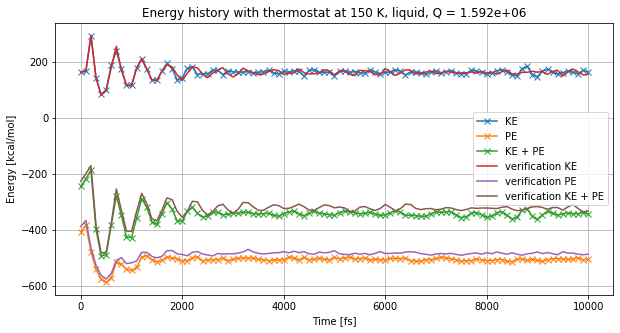

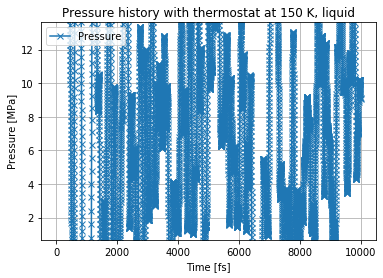

In [10]:
Q = 1592e3

def solverThermostat():
    '''
    Outputs:
    ----------
        [0] : average pressure of the last 7000 steps simulation in [MPa]
        [1] : pressure history of 10000 steps
        [2] : kinetic energy history [kcal/mol]
        [3] : potential energy history [kcal/mol]
        [4] : total energy history [kcal/mol]
        
    Instructions:
    --------------
    10000 steps cost 6[mins] with numba. Producing two files.
    
    thermostat_%s%i.dat :
        thermodynamics history data of these simulation steps, _states_temperature
    thermostat_%s%i.trj : 
        lammps trj data of these simulation step, _states_temperature
        
    '''
    
    # init variables
    coordsTemp = coords.copy()
    forcesTemp = forces.copy()
    velsTemp  = vels.copy()
    xiTemp = 0      #xiArray.copy()

    # statistics variables
    preHistory = np.zeros(steps+1)
    historyKE_TS = np.zeros(steps+1)
    historyPE_TS = np.zeros(steps+1)
    historyTOT_TS = np.zeros(steps+1)
    
    # solver loop
    for i in range(steps+1):
        coordsTemp, forcesTemp, velsTemp, xiTemp = velocityVerletThermostat(coordsTemp, forcesTemp, velsTemp, 
                                                                    xiTemp, Q, 1 )
        # get ensemble properties history 
        preHistory[i] = fnPressure(coordsTemp)
        historyKE_TS[i] = kineticEnergy(velsTemp) 
        historyPE_TS[i] = potentialEnergy(coordsTemp)
        historyTOT_TS[i] = historyKE_TS[i] + historyPE_TS[i]
        
        # sample the wanted instance
        if i % nFreq == 0 :
            KE = kineticEnergy(velsTemp)
            PE = potentialEnergy(coordsTemp)
            T = fnTemperature(KE)
            P = fnPressure(coordsTemp)
            
            
            write_frame( coordsTemp, L, velsTemp, forcesTemp, 'thermostat_%s%i.trj'%(state,Temperature), step=i)
            print('%i %.4f %.4f %.4f %.4f %.4f' %(i, T, P, KE, PE, KE+PE))
            with open('thermostat_%s%i.dat'%(state,Temperature), 'a') as file:
                file.write('%i %.4f %.4f %.4f %.4f %.4f\n' %(i, T, P, KE, PE, KE+PE))
        
#         # write xyz, for rdf only
#         if i > 3000:
#             write_xyz_traj( coordsTemp, nPart, state + str(Temperature) )
            
    # sample pressure, only after system reached equrilibrium
    avgPre = np.mean(preHistory[3000:]) 
        
    return avgPre, preHistory, historyKE_TS, historyPE_TS, historyTOT_TS

start = time.time()
avgPre, preHistory, historyKE_TS, historyPE_TS, historyTOT_TS = solverThermostat()
stop = time.time()   
print("Thermostat costs {:.2f} seconds".format( (stop-start)))
print('Average pressure at {:.0f} [K] is {:.4f} [MPa]'.format(Temperature, avgPre))



# post processing for energy history
def postProcessingTS(name, length):
    '''
    Inputs:
    ----------
    [0] : parameters history of the system, no header
    [1] : the number of frames to be plotted
    
    
    '''
    
    # initialize some variables
    xplot = np.arange(0, (length+0)*nFreq, nFreq)
    yplot0 = np.zeros(length) #KE
    yplot1 = np.zeros(length) #PE
    yplot2 = np.zeros(length) # KE+PE
    yplot3 = np.zeros(length) # verify KE
    yplot4 = np.zeros(length) # verify PE
    yplot5 = np.zeros(length) # verify KE + PE
    pressureHistory = np.zeros(length)

    file = open(name,'r')   
    for i in range(length):
        line = file.readline()
        line = line.split()
        yplot0[i] = line[3]
        yplot1[i] = line[4]
        yplot2[i] = line[5]           
        
    # read the verfication data
    cnt = 0
    with open("log.lammps1", "r") as file:
            for line in file:
                cnt += 1
                if cnt > 47 and cnt < 47 + length +1:
                    line = line.split()
                    yplot3[cnt-48] = line[3]
                    yplot4[cnt-48] = line[4]
                    yplot5[cnt-48] = line[5]
    
    # plots
    
    plt.figure(figsize = (10,5))
    plt.title('Energy history with thermostat at %i K, %s, Q = %.3e'%(Temperature, state, Q) )
    plt.xlabel('Time [fs]'); plt.ylabel('Energy [kcal/mol]')
    plt.plot(xplot, yplot0,'-x', label = 'KE')
    plt.plot(xplot, yplot1,'-x', label = 'PE')
    plt.plot(xplot, yplot2,'-x', label = 'KE + PE')
    plt.plot(xplot, yplot3, label = 'verification KE')
    plt.plot(xplot, yplot4, label = 'verification PE')
    plt.plot(xplot, yplot5, label = 'verification KE + PE')
    plt.legend(loc = 7); plt.grid()
    plt.savefig('energyHistoryTS.png')
    
    # plot pressue history
    plt.figure()
    plt.title('Pressure history with thermostat at %i K, %s'%(Temperature, state) )
    plt.xlabel('Time [fs]'); plt.ylabel('Pressure [MPa]')
    plt.plot(np.arange(len(preHistory)), preHistory,'-x', label = 'Pressure')
    plt.legend(loc = 'best'); plt.grid()
    plt.ylim(avgPre*0.1, avgPre*2)
    plt.savefig('preHistory_%s%i.png'%(state,Temperature))
    

postProcessingTS('thermostat_%s%i.dat'%(state,Temperature), int(steps/nFreq) + 1 )





In [11]:
# compute the two stage statisics
def getStatistics():
    
    # first stage sample data of first 1000 steps (not equlibriated)
    avgKE0, sdKE0 = averages(historyKE[:1000])
    avgPE0, sdPE0 = averages(historyPE)[:1000]
    avgTOT0, sdTOT0 = averages(historyTOT[:1000])
    # second stage sample data of last 9000 steps (equlibriated)
    avgKE1, sdKE1 = averages(historyKE[1000:])
    avgPE1, sdPE1 = averages(historyPE[1000:])
    avgTOT1, sdTOT1 = averages(historyTOT[1000:])
    
    print('First 1000 steps give avgKE = %.2f , sdKE = %.2f , '\
          'avgPE = %.2f , sdPE = %.2f , avgTOT = %.2f , sdTOT = %.2f \n'
          'Last 9000 steps give avgKE = %.f , sdKE = %.2f , '\
          'avgPE = %.2f , sdPE = %.2f , avgTOT = %.2f , sdTOT = %.2f \n'\
          %(avgKE0, sdKE0, avgPE0, sdPE0, avgTOT0, sdTOT0, avgKE1, sdKE1, avgPE1, sdPE1, avgTOT1, sdTOT1)
         )
    
def getStatisticsTS():
    
    # first stage sample data of first 3000 steps (not equlibriated)
    avgKE0, sdKE0 = averages(historyKE_TS[:3000])
    avgPE0, sdPE0 = averages(historyPE_TS)[:3000]
    avgTOT0, sdTOT0 = averages(historyTOT_TS[:3000])
    # second stage sample data of last 7000 steps (equlibriated)
    avgKE1, sdKE1 = averages(historyKE_TS[3000:])
    avgPE1, sdPE1 = averages(historyPE_TS[3000:])
    avgTOT1, sdTOT1 = averages(historyTOT_TS[3000:])
    
    print('First 3000 steps give avgKE = %.2f , sdKE = %.2f , '\
          'avgPE = %.2f , sdPE = %.2f , avgTOT = %.2f , sdTOT = %.2f \n'
          'Last 7000 steps give avgKE = %.f , sdKE = %.2f , '\
          'avgPE = %.2f , sdPE = %.2f , avgTOT = %.2f , sdTOT = %.2f \n'\
          %(avgKE0, sdKE0, avgPE0, sdPE0, avgTOT0, sdTOT0, avgKE1, sdKE1, avgPE1, sdPE1, avgTOT1, sdTOT1)
         )

    
getStatistics()    
getStatisticsTS()

First 1000 steps give avgKE = 236.80 , sdKE = 51.29 , avgPE = -476.93 , sdPE = 17.07 , avgTOT = -245.59 , sdTOT = 0.42 
Last 9000 steps give avgKE = 231 , sdKE = 5.59 , avgPE = -476.33 , sdPE = 5.59 , avgTOT = -245.22 , sdTOT = 0.02 

First 3000 steps give avgKE = 161.92 , sdKE = 38.76 , avgPE = -506.67 , sdPE = 22.76 , avgTOT = -348.13 , sdTOT = 63.03 
Last 7000 steps give avgKE = 162 , sdKE = 6.27 , avgPE = -505.22 , sdPE = 4.14 , avgTOT = -343.13 , sdTOT = 7.22 



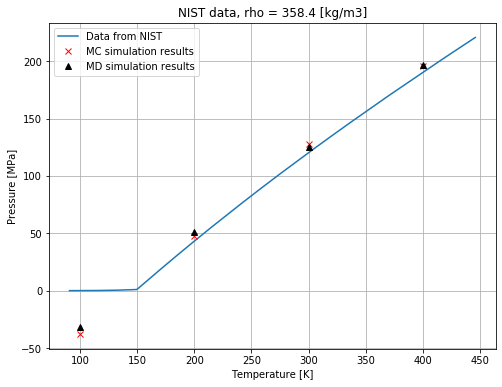

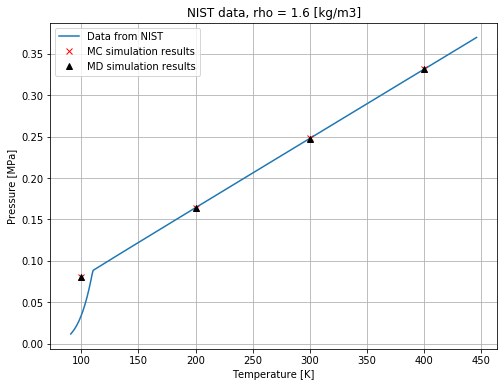

In [12]:
# postprocessing for pressure
def NIST358():
    '''
    Instructions:
    -------------
        To get the pressure under different temperature, one need to run solverThermostat() 
        under different temperatures, the data in the array are collected results
    
    '''
    
    T, P = np.zeros(400), np.zeros(400)
    i = 0
    with open("NIST358.txt", "r") as file:
        for line in file:
            line = line.split()
            T[i] = line[0]
            P[i] = line[1]
            i += 1
            if i>399: 
                break
    
    # wanted temperature
    Tmc358 = np.array([100, 200, 300, 400])
    Pmc358 = np.array([-37.7435, 47.5158, 127.6414, 195.6832 ])
    Pmd358 = np.array([-31.4932, 51.4440, 125.3344, 196.8555 ])    #  -36.7320  48.0829  127.0458 191.2055
    
    # plot the figure
    plt.figure(figsize = (8,6))
    plt.title("NIST data, rho = 358.4 [kg/m3]")
    plt.plot(T, P, label = 'Data from NIST')
    plt.plot(Tmc358, Pmc358, 'rx',label = 'MC simulation results')
    plt.plot(Tmc358, Pmd358, 'k^',label = 'MD simulation results')
    plt.xlabel('Temperature [K]')
    plt.ylabel('Pressure [MPa]')
    plt.legend(); plt.grid()
 
def NIST1():
    '''
    Instructions:
    -------------
        To get the pressure under different temperature, one need to run solverThermostat() 
        under different temperatures, the data in the array are collected results
    
    '''
    T, P = np.zeros(400), np.zeros(400)
    i = 0
    with open("NIST1.txt", "r") as file:
        for line in file:
            line = line.split()
            T[i] = line[0]
            P[i] = line[1]
            i += 1
            if i>399: 
                break
    
    # wanted temperature
    Tmc1 = np.array([100, 200, 300, 400])
    Pmc1 = np.array([0.0805, 0.1642, 0.2479, 0.3316 ])
    Pmd1 = np.array([0.0805, 0.1640, 0.2473, 0.3316 ])
    
    # plot the figure
    plt.figure(figsize = (8,6))
    plt.title("NIST data, rho = 1.6 [kg/m3]")
    plt.plot(T, P, label = 'Data from NIST')
    plt.plot(Tmc1, Pmc1, 'rx',label = 'MC simulation results')
    plt.plot(Tmc1, Pmd1, 'k^',label = 'MD simulation results')
    plt.xlabel('Temperature [K]')
    plt.ylabel('Pressure [MPa]')
    plt.legend(); plt.grid()

    
    
NIST358()
NIST1()

In [13]:
# ================  RDF ==========================
# uncomment this part only when do RDF compute, also uncomment xyz generator in thermostat function

# write the initial coordinates for part 1 
# write_xyz_traj(coords, nPart, 'initRho')
# write_xyz_traj(coords_1, int(nPart*0.5), 'initRho_1')
# write_xyz_traj(coords_2, nPart*2, 'initRho_2')

# plotting
def rdfplot(T):
    '''
    Instructions:
    --------------
        initRho.xyz, initRho_1.xyz, initRho_2.xyz are the files to read to get rdf of initial state for checking
        state + str(T) + '.xyz' are the file to read rdf of different temperature and states. 
            xyz file was generated by write_xyz_traj() inside thermostat function.
        
        reading 7000 frames cost 7 mins.
    '''
    
    nbins = 149
    gr = np.zeros(nbins)
    LXLYLZ = np.array([L, L, L])
    if state == 'liquid':
        rdfRange = (0.1, 15.0)
    elif state == 'gas':
        rdfRange = (0.1, 30.0)
        
    xyz = read_xyz_trj(state + str(T) + '.xyz')
    
    for key in xyz.keys():
        r, temp0 = rdf(xyz[key], LXLYLZ, nbins, rdfRange)
        gr += temp0
        
    gr /= len(xyz.keys())
    
    plt.figure()
    plt.title("RDF plot of %s CH4 at %.0f [K], MD "%(state, T) )
    plt.plot(r, gr)
    plt.xlabel('r [$\AA$]'); plt.ylabel('g(r)'); plt.grid(True)
    plt.savefig(state + str(T) + '.png')
    
start = time.time()
# rdfplot(Temperature)
stop = time.time()   
print("cost %.2f seconds" %( stop-start))

cost 0.00 seconds
